In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

np.random.seed(0)

# ELEC2 data set from https://www.kaggle.com/yashsharan/the-elec2-dataset
data = pd.read_csv("data/electricity-normalized.csv")

# Feature columns
features_col = ["period", "nswprice", "nswdemand", "vicprice", "vicdemand"]

# Target column
target_col = "transfer"

# Remove first sequence where electricity tansfer does not change
data = data.iloc[20000:]

# keep data points for 9:00am - 12:00pm
# each period is measure in half hour intervals over 24 hours and normalized between 0 and 1
time_window_filter = (data.period >= 9 * 2 / 48) & (data.period <= 12 * 2 / 48)
data = data[time_window_filter]

# Cast data to numpy array
X = data[features_col].to_numpy()
y = data[target_col].to_numpy()


In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from deel.puncc.api.prediction import BasePredictor, DualPredictor

# Instantiate linear model and wrap it in a BasePredictor
model = LinearRegression()
predictor = BasePredictor(model, is_trained=False)


In [8]:
from deel.puncc.regression import SplitCP, EnbPI, CQR, AdaptiveEnbPI

# Define CP algorithms

## SCP
split_cp = SplitCP(predictor, train=True)


### Weight function
def exp_decay(X):
    return [0.99 ** (len(X) + 1 - i) for i in range(len(X))]


## WSCP
weighted_split_cp = SplitCP(predictor, weight_func=exp_decay, train=True)

## EnbPI
enbpi = EnbPI(predictor, B=20, random_state=0)


In [9]:
from tqdm import tqdm
from deel.puncc.metrics import regression_mean_coverage, regression_sharpness

results = []

# Target error rate
alpha = 0.1

# Increment to update sliding windows
counter = 0

# Size of the training set
time_lag = 100

# time_lag + length give total size of the used data
length = 700

for test_index in tqdm(range(time_lag + 100, time_lag + length)):
    # Partition data into fit, calibration and test
    X_fit, y_fit = X[: time_lag + counter], y[: time_lag + counter]
    X_calib, y_calib = (
        X[time_lag + counter : test_index],
        y[time_lag + counter : test_index],
    )
    X_calib, y_calib = (
        X[time_lag + 1 : test_index],
        y[time_lag + 1 : test_index],
    )
    X_test, y_test = X[test_index], y[test_index]

    # SCP: fit, predict and metrics
    split_cp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)
    y_pred_scp, y_pred_lower_scp, y_pred_upper_scp = split_cp.predict(
        X_test[np.newaxis, ...], alpha=alpha
    )
    coverage_scp = regression_mean_coverage(
        y_test, y_pred_lower_scp, y_pred_upper_scp
    )
    width_scp = regression_sharpness(y_pred_lower_scp, y_pred_upper_scp)
    results.append(
        [
            "Split CP",
            test_index,
            float(y_pred_scp),
            y_pred_lower_scp,
            y_pred_upper_scp,
            coverage_scp,
            width_scp,
        ]
    )

    # WSCP: fit, predict and metrics
    weighted_split_cp.fit(
        X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib
    )
    (
        y_pred_wscp,
        y_pred_lower_wscp,
        y_pred_upper_wscp,
    ) = weighted_split_cp.predict(X_test[np.newaxis, ...], alpha=alpha)
    coverage_wscp = regression_mean_coverage(
        y_test, y_pred_lower_wscp, y_pred_upper_wscp
    )
    width_wscp = regression_sharpness(y_pred_lower_wscp, y_pred_upper_wscp)
    results.append(
        [
            "Weighted split CP",
            test_index,
            float(y_pred_wscp),
            y_pred_lower_wscp,
            y_pred_upper_wscp,
            coverage_wscp,
            width_wscp,
        ]
    )

    # EnbPI: fit, predict and metrics
    enbpi.fit(X[counter:test_index], y[counter:test_index])
    y_pred_enbpi, y_pred_lower_enbpi, y_pred_upper_enbpi = enbpi.predict(
        X_test[np.newaxis, ...], alpha=alpha
    )
    coverage_enbpi = regression_mean_coverage(
        y_test, y_pred_lower_enbpi[0], y_pred_upper_enbpi[0]
    )
    width_enbpi = regression_sharpness(
        y_pred_lower_enbpi[0], y_pred_upper_enbpi[0]
    )
    results.append(
        [
            "EnbPI",
            test_index,
            y_pred_enbpi[0],
            y_pred_lower_enbpi[0],
            y_pred_upper_enbpi[0],
            coverage_enbpi,
            width_enbpi,
        ]
    )

    # Update sliding window increment
    counter += 1

columns = [
    "method",
    "time",
    "y_pred",
    "y_pred_lower",
    "y_pred_upper",
    "coverage",
    "width",
]
results_df = pd.DataFrame(results, columns=columns)
y_test = y[np.arange(time_lag + 100, time_lag + length)]


100%|██████████| 600/600 [01:37<00:00,  6.17it/s]


In [10]:
results_df.groupby(["method"])[["coverage", "width"]].mean()


,coverage,width
method,,
EnbPI,0.90,0.319347
Split CP,0.84,0.364155
Weighted split CP,0.89,0.405216


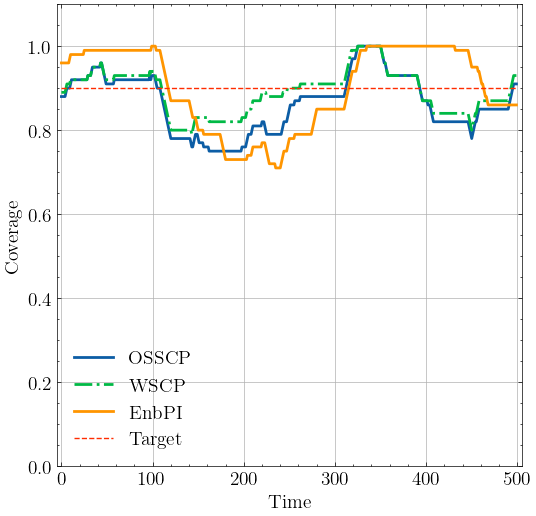

In [7]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
# Edit the font, font size, and axes width
plt.rcParams['font.size'] = 14

window = 100

fig, ax = plt.subplots(figsize=(6,6))

def moving_average(y,window):
    return np.convolve(y,np.ones(window)/window)[(window-1):-window]
    
coverage_scp_ts = results_df[results_df.method == "Split CP"].coverage
coverage_wscp_ts = results_df[results_df.method == "Weighted split CP"].coverage
coverage_enbpi_ts = results_df[results_df.method == "EnbPI"].coverage
# coverage_aenbpi_ts = (y_test > y_pred_lower_aenbpi)&(y_test < y_pred_upper_aenbpi)

%matplotlib inline
ax.plot(moving_average(coverage_scp_ts, window), label="OSSCP", linewidth=2)
ax.plot(moving_average(coverage_wscp_ts, window), "-.", label="WSCP", linewidth=2)
ax.plot(moving_average(coverage_enbpi_ts, window), label="EnbPI", linewidth=2)
ax.plot((1-alpha)*np.ones_like(moving_average(coverage_enbpi_ts, window)), "--", label="Target")
ax.set_xlim([-5,505])
ax.set_ylim([0,1.1])
ax.set_xlabel("Time")
ax.set_ylabel("Coverage")

# plt.plot(moving_average(coverage_aenbpi_ts[300:], 300), label="aEnbPI")
ax.legend()

plt.grid()

#plt.savefig("regression_coverage_moving_window.pdf")

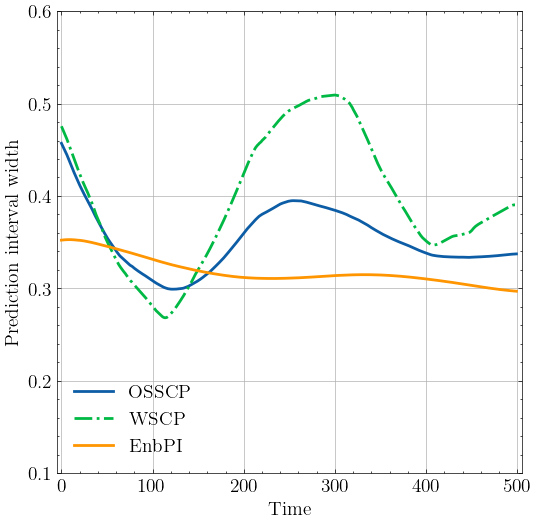

In [198]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science"])
# Edit the font, font size, and axes width
plt.rcParams["font.size"] = 14

window = 100

fig, ax = plt.subplots(figsize=(6, 6))


def moving_average(y, window):
    return np.convolve(y, np.ones(window) / window)[(window - 1) : -window]


width_scp_ts = results_df[results_df.method == "Split CP"].width
width_wscp_ts = results_df[results_df.method == "Weighted split CP"].width
width_enbpi_ts = results_df[results_df.method == "EnbPI"].width

ax.plot(moving_average(width_scp_ts, window), label="OSSCP", linewidth=2)
ax.plot(moving_average(width_wscp_ts, window), "-.", label="WSCP", linewidth=2)
ax.plot(moving_average(width_enbpi_ts, window), label="EnbPI", linewidth=2)
ax.set_xlim([-5, 505])
ax.set_ylim([0.1, 0.6])
ax.legend(loc="lower left")
ax.set_xlabel("Time")
ax.set_ylabel("Prediction interval width")

plt.grid()
plt.savefig("regression_width_moving_window.pdf")


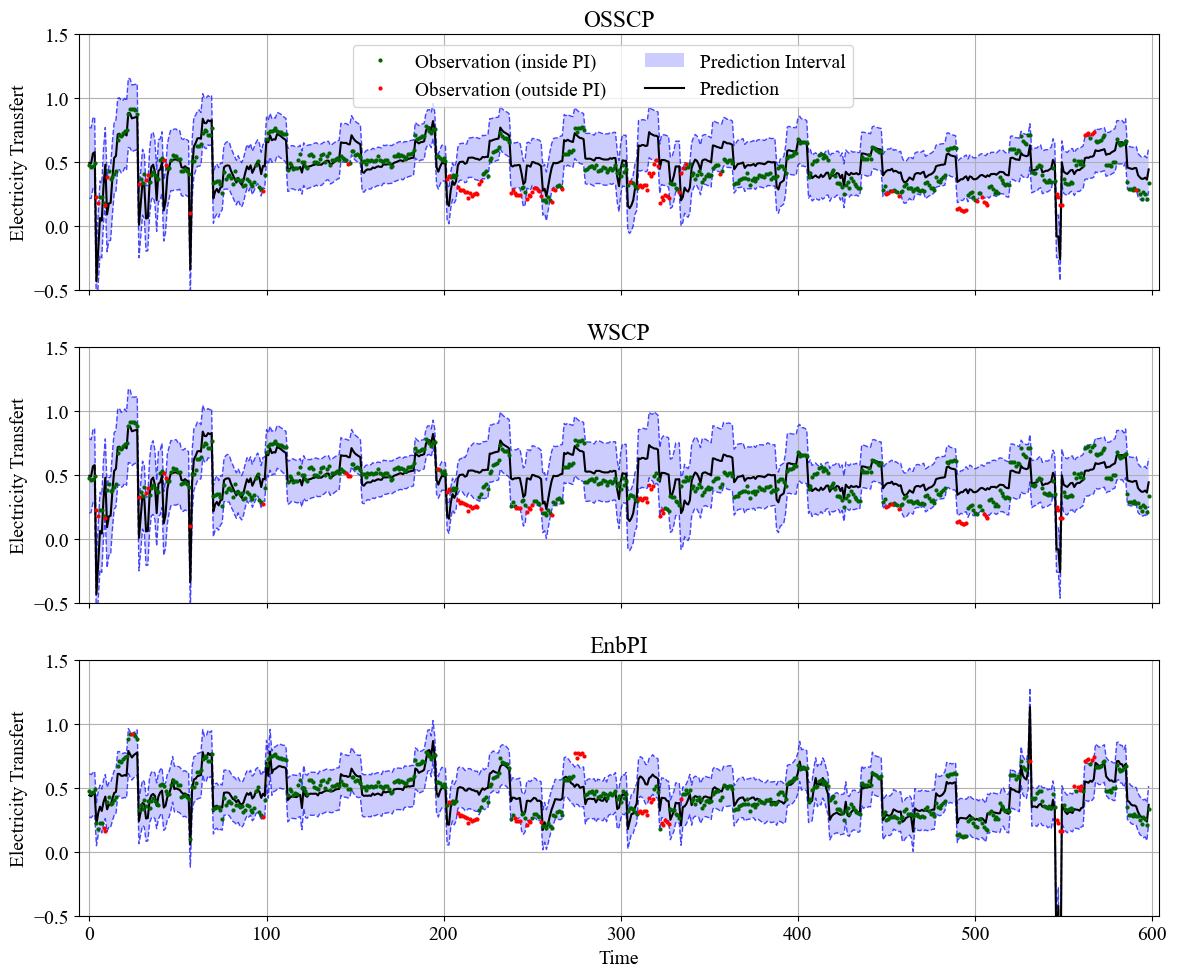

In [172]:
import matplotlib.pyplot as plt
from deel.puncc.plotting import plot_prediction_intervals

# Recover point and interval prediction for the three methods:

## SCP
y_pred_scp = results_df[results_df.method == "Split CP"].y_pred.values
y_pred_lower_scp = results_df[
    results_df.method == "Split CP"
].y_pred_lower.values
y_pred_upper_scp = results_df[
    results_df.method == "Split CP"
].y_pred_upper.values

## WSCP
y_pred_wscp = results_df[results_df.method == "Weighted split CP"].y_pred.values
y_pred_lower_wscp = results_df[
    results_df.method == "Weighted split CP"
].y_pred_lower.values
y_pred_upper_wscp = results_df[
    results_df.method == "Weighted split CP"
].y_pred_upper.values

## EnbPI
y_pred_enbpi = results_df[results_df.method == "EnbPI"].y_pred.values
y_pred_lower_enbpi = results_df[
    results_df.method == "EnbPI"
].y_pred_lower.values
y_pred_upper_enbpi = results_df[
    results_df.method == "EnbPI"
].y_pred_upper.values

horizon = -1

fig, axes = plt.subplots(nrows=3, figsize=(12, 10), sharex=True)

plot_prediction_intervals(
    y_test[:horizon],
    y_pred_lower_scp[:horizon],
    y_pred_upper_scp[:horizon],
    y_pred=y_pred_scp[:horizon],
    ax=axes[0],
    loc="upper right",
)
axes[0].set_xlabel("")
axes[0].set_title("OSSCP")
axes[0].set_ylabel("Electricity Transfert")
axes[0].set_ylim([-0.5, 1.5])

plot_prediction_intervals(
    y_test[:horizon],
    y_pred_lower_wscp[:horizon],
    y_pred_upper_wscp[:horizon],
    y_pred=y_pred_wscp[:horizon],
    ax=axes[1],
    loc="upper right",
)
axes[1].set_xlabel("")
axes[1].set_title("WSCP")
axes[1].set_ylabel("Electricity Transfert")
axes[1].set_ylim([-0.5, 1.5])

plot_prediction_intervals(
    y_test[:horizon],
    y_pred_lower_enbpi[:horizon],
    y_pred_upper_enbpi[:horizon],
    y_pred=y_pred_enbpi[:horizon],
    ax=axes[2],
    loc="upper right",
)
plt.ylim([-1, 2])
axes[2].set_xlabel("Time")
axes[2].set_title("EnbPI")
axes[2].set_ylabel("Electricity Transfert")
axes[2].set_ylim([-0.5, 1.5])

plt.tight_layout()

plt.rcParams["font.size"] = 14

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.3, 0.89), ncol=2)
plt.rcParams["font.family"] = "Times New Roman"

axes[0].grid()
axes[1].grid()
axes[2].grid()

plt.savefig("ts_regression_plot.pdf")
